<a href="https://colab.research.google.com/github/lcfdiniz/puc-rio/blob/main/flood-area-segmentation/flood-area-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Segmentação de área de inundações

por [Lucas Fiorani Diniz](https://www.linkedin.com/in/lcfdiniz/)

## Definição do Problema

As enchentes e inundações representam um grande desafio para o Brasil, um país com vasta extensão territorial, grandes bacias hidrográficas e condições climáticas diversas.

As inundações ocorrem quando a capacidade dos rios, córregos, lagos e sistemas de drenagem é ultrapassada, resultando no transbordamento de água para áreas não projetadas para suportar volumes tão elevados.

Diversos fatores contribuem para o aumento do risco de inundações no Brasil, incluindo a urbanização desordenada, mudanças no uso do solo, desmatamento, assoreamento dos rios, falta de infraestrutura adequada e eventos climáticos extremos.

A chegada do El Niño [[1]](https://veja.abril.com.br/agenda-verde/secas-enchentes-e-calorao-como-o-el-nino-afeta-o-brasil) em julho de 2023, por exemplo, promete intensificar o regime de chuvas nas regiões Sul e Sudeste, o que aliado a falta de infraestrutura adequada de drenagem, pode levar a inundações rápidas e devastadoras, resultando em danos materiais, deslocamentos populacionais e perda de vidas.

Nesse cenário, o uso de técnicas de inteligência artificial se mostra uma medida promissora, auxiliando comunidades e regiões no enfrentamento e recuperação desses desastres.

Esse trabalho propõe o desenvolvimento de um modelo de segmentação semântica de imagens para detecção de áreas de inundação. Entre as oportunidades oferecidas por um modelo como esse, estão:

- Identificação de áreas afetadas pelas inundações, ajudando na avaliação rápida e precisa do alcance e extensão desses fenônomenos em determinada região;

- Monitoramento em tempo real de enchentes e inundações, detectando áreas mais críticas e servindo de apoio a decisão de equipes de emergência;

- Gerar dados para um melhor planejamento urbano, permitindo medidas preventivas mais assertivas, como a construção de infraestrutura adequada e melhorias dos sistemas de drenagem.

O modelo treinado ainda poderia ser aplicado na estimativa de área inundada por reservatórios de usinas hidrelétricas, ajudando no controle operacional das mesmas.

### Restrições e condições respeitadas

Para se obter os dados do problema, a plataforma [Kaggle](https://www.kaggle.com/datasets) foi consultada. O Kaggle é a maior comunidade online de cientistas de dados e praticantes de Machine Learning, disponibilizando recursos valiosos para seus usuários, como datasets variados.

O melhor dataset encontrado para o problema foi o [*Flood Area Segmentation*](https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation). Esse conjunto de dados possui imagens de inundações acompanhadas das respectivas máscaras binárias, identificando os pixels correspondente às áreas de enchente.

Algumas considerações devem ser feitas a respeito desse dataset:

- O baixo número de imagens (290) indica que o uso de técnicas de *data augmentation* e modelos pré-treinados pode ser eficaz;

- O ângulo de captura das imagens pode ser um fator limitante para a correta estimativa da área afetada, devido às possíveis distorções dos elementos do cenário. Imagens aéreas com a câmera totalmente apontada para baixo podem evitar esse problema.

### Dataset utilizado

O dataset utilizado possui 290 imagens de enchentes em formato JPG, acompanhadas de suas respectivas máscaras binárias em formato PNG. O conjunto de dados é acompanhado ainda de um arquivo contendo os metadados, `metadata.csv`, que registra a relação entre cada par de imagem e máscara.

Para atender as dimensões máximas de arquivos permitidas pelo GitHub, o conjunto de imagens foi previamente dividido entre treino, validação e teste, seguindo uma razão de 70/30/30. Dessa forma, o conjunto de treino contém 200 imagens, enquanto os conjuntos de validação e teste apresentam 45 cada.

In [47]:
# Criando os diretórios para o dataset
!mkdir -p dataset/{images/{train,valid,test},masks/{train,valid,test}}

In [ ]:
# Realizando o download das imagens

# Treino
!wget https://github.com/lcfdiniz/puc-rio/raw/main/flood-area-segmentation/data/images/train.zip -P /content/dataset/images/train/
!unzip /content/dataset/images/train/train.zip -d /content/dataset/images/train/
!rm /content/dataset/images/train/train.zip

# Validação
!wget https://github.com/lcfdiniz/puc-rio/raw/main/flood-area-segmentation/data/images/valid.zip -P /content/dataset/images/valid/
!unzip /content/dataset/images/valid/valid.zip -d /content/dataset/images/valid/
!rm /content/dataset/images/valid/valid.zip

# Teste
!wget https://github.com/lcfdiniz/puc-rio/raw/main/flood-area-segmentation/data/images/test.zip -P /content/dataset/images/test/
!unzip /content/dataset/images/test/test.zip -d /content/dataset/images/test/
!rm /content/dataset/images/test/test.zip

In [57]:
len(os.listdir("/content/dataset/images/train")), len(os.listdir("/content/dataset/images/valid")), len(os.listdir("/content/dataset/images/test"))

(200, 45, 45)

In [ ]:
# Realizando o download das máscaras

# Treino
!wget https://github.com/lcfdiniz/puc-rio/raw/main/flood-area-segmentation/data/masks/train.zip -P /content/dataset/masks/train/
!unzip /content/dataset/masks/train/train.zip -d /content/dataset/masks/train/
!rm /content/dataset/masks/train/train.zip

# Validação
!wget https://github.com/lcfdiniz/puc-rio/raw/main/flood-area-segmentation/data/masks/valid.zip -P /content/dataset/masks/valid/
!unzip /content/dataset/masks/valid/valid.zip -d /content/dataset/masks/valid/
!rm /content/dataset/masks/valid/valid.zip

# Teste
!wget https://github.com/lcfdiniz/puc-rio/raw/main/flood-area-segmentation/data/masks/test.zip -P /content/dataset/masks/test/
!unzip /content/dataset/masks/test/test.zip -d /content/dataset/masks/test/
!rm /content/dataset/masks/test/test.zip

In [56]:
len(os.listdir("/content/dataset/masks/train")), len(os.listdir("/content/dataset/masks/valid")), len(os.listdir("/content/dataset/masks/test"))

(200, 45, 45)

Para facilitar o entendimento dos dados do problema, será criado um dataframe com uma entrada para cada imagem, contendo seu nome, máscara correspondente, conjunto ao qual pertence (treino, validação ou teste), altura, largura, número de canais e tamanho do arquivo.

In [103]:
# Lendo os metadados
url = "https://raw.githubusercontent.com/lcfdiniz/puc-rio/main/flood-area-segmentation/data/metadata.csv"
metadata_df = pd.read_csv(url)

metadata_df.head()

Image   Mask
0  0.jpg  0.png
1  1.jpg  1.png
2  2.jpg  2.png
3  3.jpg  3.png
4  4.jpg  4.png

In [120]:
# Dicionário para correspondências entre imagens e máscaras
img2mask = metadata_df.set_index('Image')['Mask'].to_dict()

In [124]:
# Criação do dataset
names, masks, splits, heights, widths, channels, filesize = [], [], [], [], [], [], []

for path, subdirs, files in os.walk("/content/dataset/images"):
    for file in files:
      img_shape = mpimg.imread(os.path.join(path, file)).shape
      names.append(file)
      masks.append(img2mask[file])
      splits.append(os.path.basename(path))
      heights.append(img_shape[0])
      widths.append(img_shape[1])
      channels.append(img_shape[2])
      filesize.append(os.path.getsize(os.path.join(path, file)))

df = pd.DataFrame({'image': names, 'mask': masks, 'split': splits, 'height': heights,
                   'width': widths, 'channels': channels, 'filesize': filesize})

df.head()

image      mask  split  height  width  channels  filesize
0     1.jpg     1.png  train     300    500         3    159547
1  1072.jpg  1072.png  train     680   1024         3    133176
2  3005.jpg  3005.png  train     366    640         3     99780
3  2035.jpg  2035.png  train     950    634         3    173051
4  1039.jpg  1039.png  train     685   1024         3    128990

In [125]:
df.describe()

height        width    channels      filesize
count   290.000000   290.000000  290.000000  2.900000e+02
mean    732.682759  1155.179310    3.010345  3.689229e+05
std     595.548158   906.546274    0.101357  1.124818e+06
min     219.000000   330.000000    3.000000  1.087700e+04
25%     414.000000   635.500000    3.000000  6.259550e+04
50%     540.000000   900.000000    3.000000  1.130665e+05
75%     743.250000  1200.000000    3.000000  2.529660e+05
max    3648.000000  5472.000000    4.000000  1.435458e+07

In [126]:
df.describe(include='object')

image   mask  split
count     290    290    290
unique    290    290      3
top     1.jpg  1.png  train
freq        1      1    200

Algumas imagens parecem possuir 4 canais, o que deve ser verificado:

In [127]:
df[df["channels"]>3]

image      mask  split  height  width  channels  filesize
135     2.jpg     2.png  train     450    640         4    654772
141     0.jpg     0.png  train     551    893         4    368278
202  3048.jpg  3048.png  valid     381    640         4    174702

Para arquivos no formato JPG, o quarto canal representa o canal *alpha*, que determina a transparência ou opacidade de cada pixel na imagem. Para a aplicação proposta, esse canal será simplesmente ignorado quando presente.

Podemos também visualizar algumas das imagens e máscaras do conjunto de dados utilizado:

In [117]:
def show_data(files, images_dir, masks_dir):

  for file in files:
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

    # Exibe a imagem
    axs[0].imshow(mpimg.imread(os.path.join(images_dir, file)))
    axs[0].set_title('Imagem', fontdict={'fontsize':20})
    axs[0].grid(False)
    axs[0].axis(True)

    # Exibe a máscara
    axs[1].imshow(mpimg.imread(os.path.join(masks_dir,os.path.splitext(file)[0]+'.png')))
    axs[1].set_title('Máscara', fontdict={'fontsize':20})
    axs[1].grid(False)
    axs[1].axis(True)

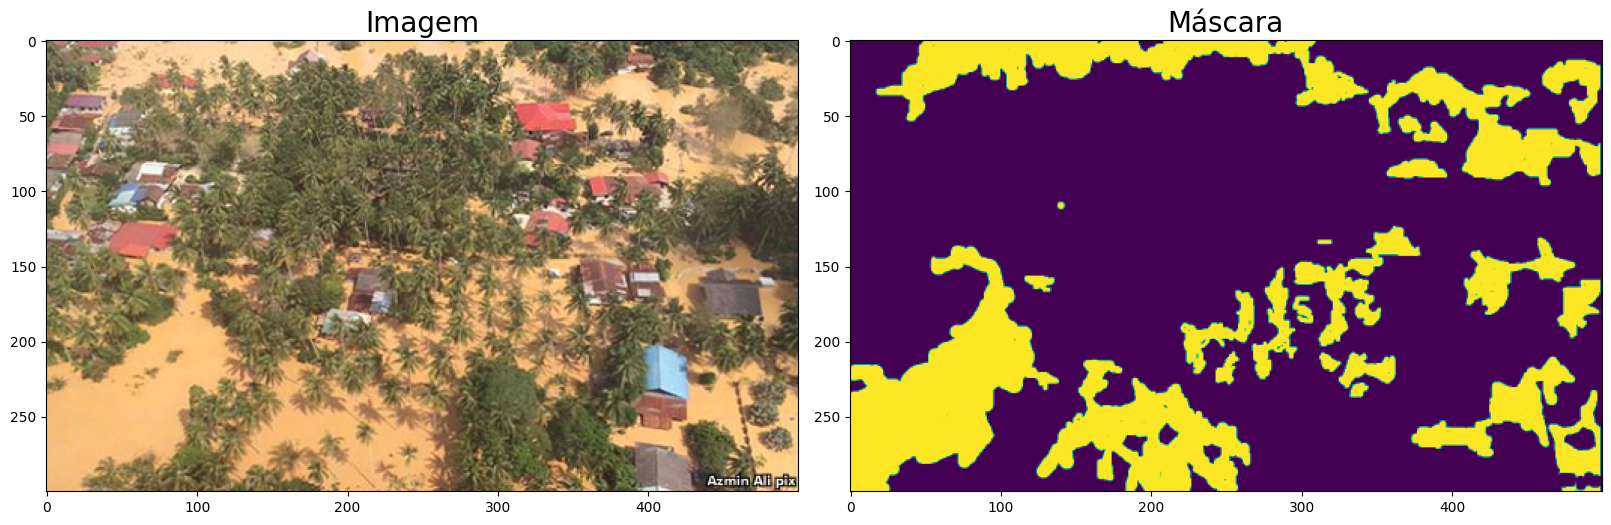

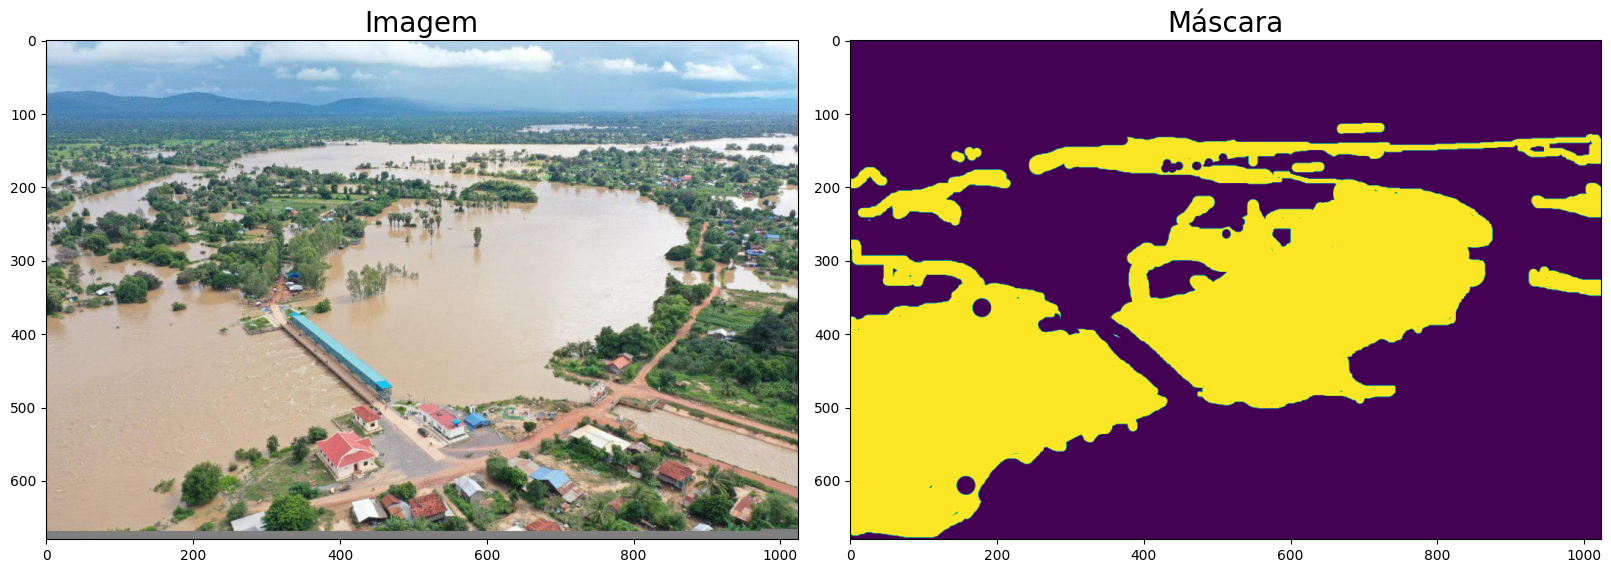

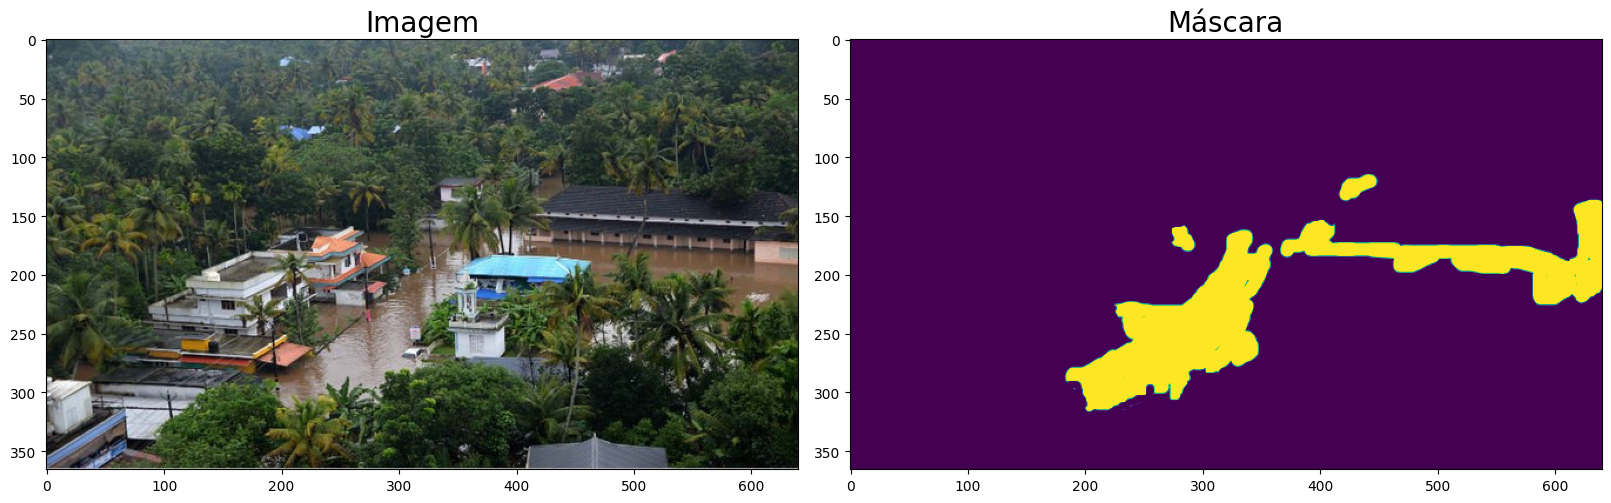

In [118]:
images = os.listdir("/content/dataset/images/train")

# Exibindo as três primeiras imagens de treino e suas máscaras correspondentes
show_data(images[:3], "/content/dataset/images/train/", "/content/dataset/masks/train/")

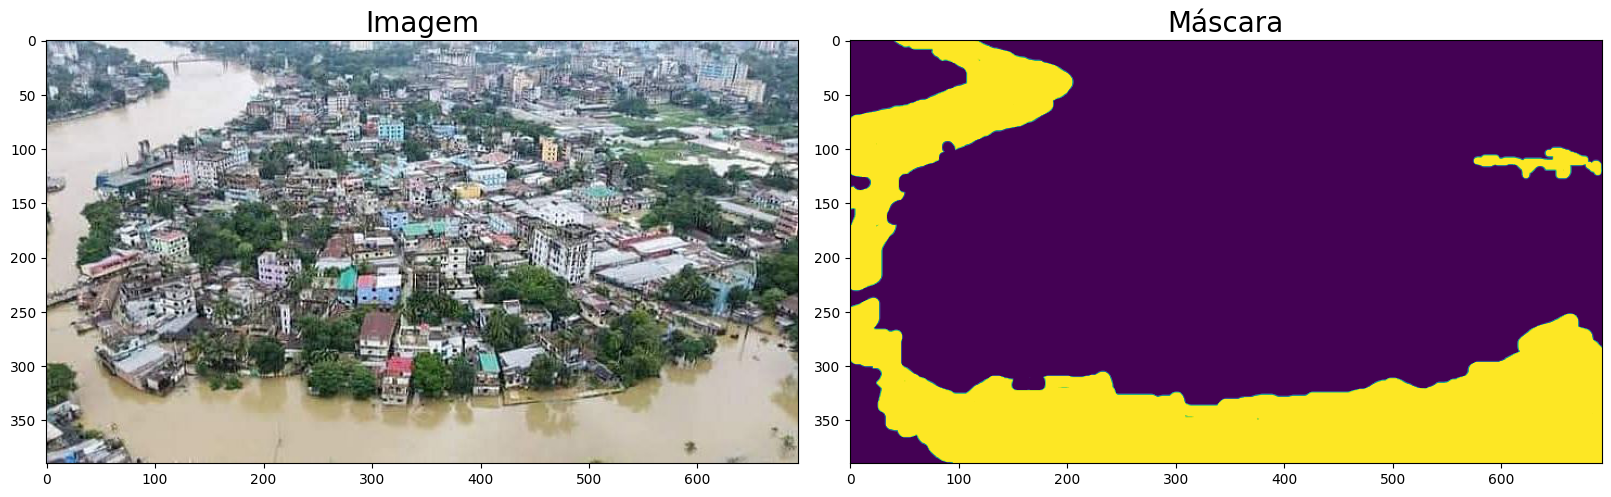

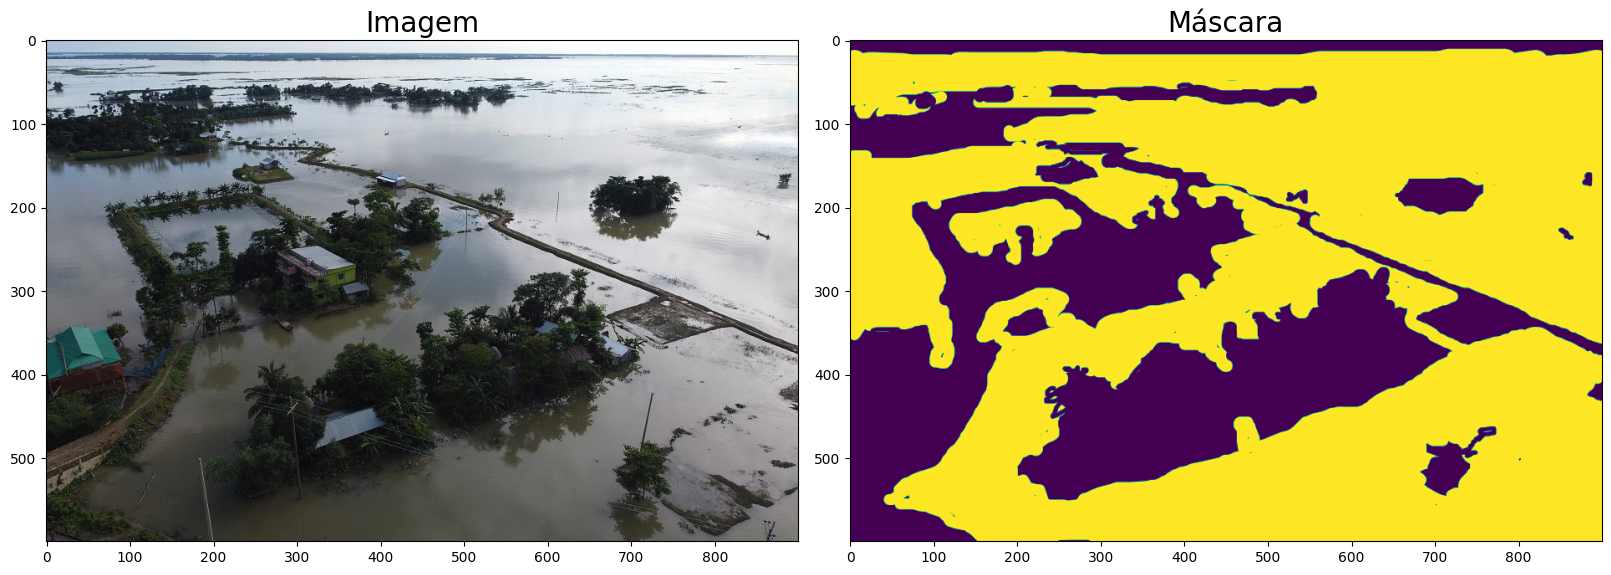

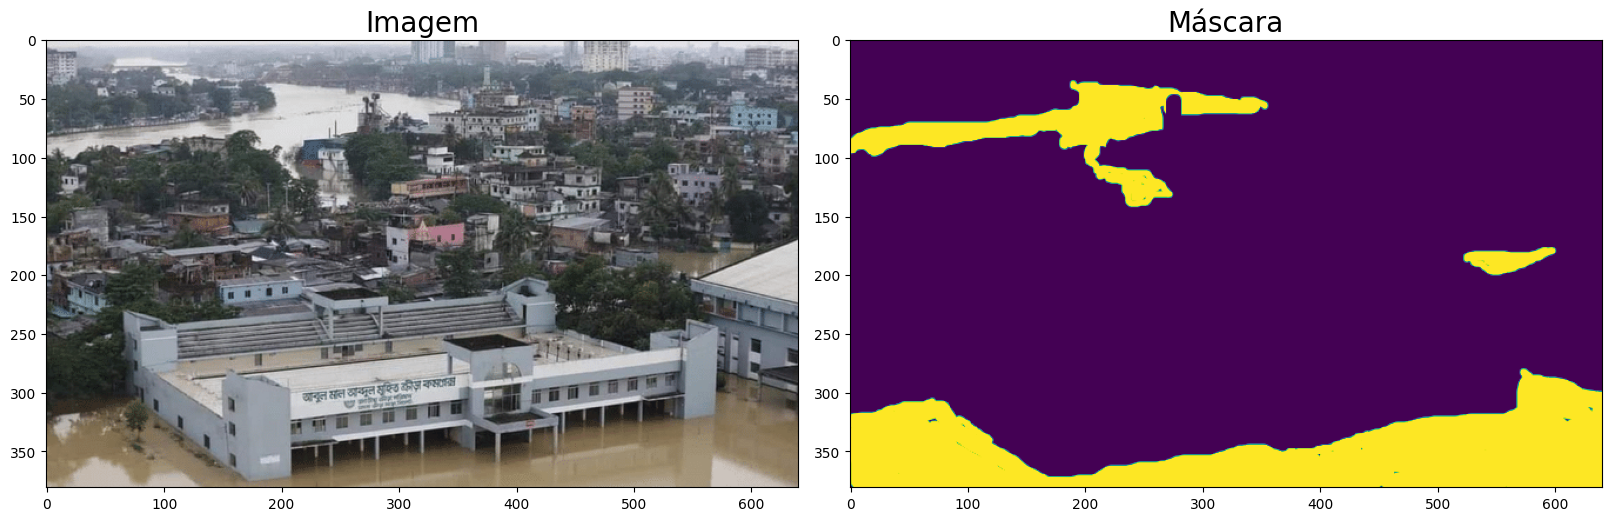

In [128]:
images = os.listdir("/content/dataset/images/valid")

# Exibindo as três primeiras imagens de validação e suas máscaras correspondentes
show_data(images[:3], "/content/dataset/images/valid/", "/content/dataset/masks/valid/")

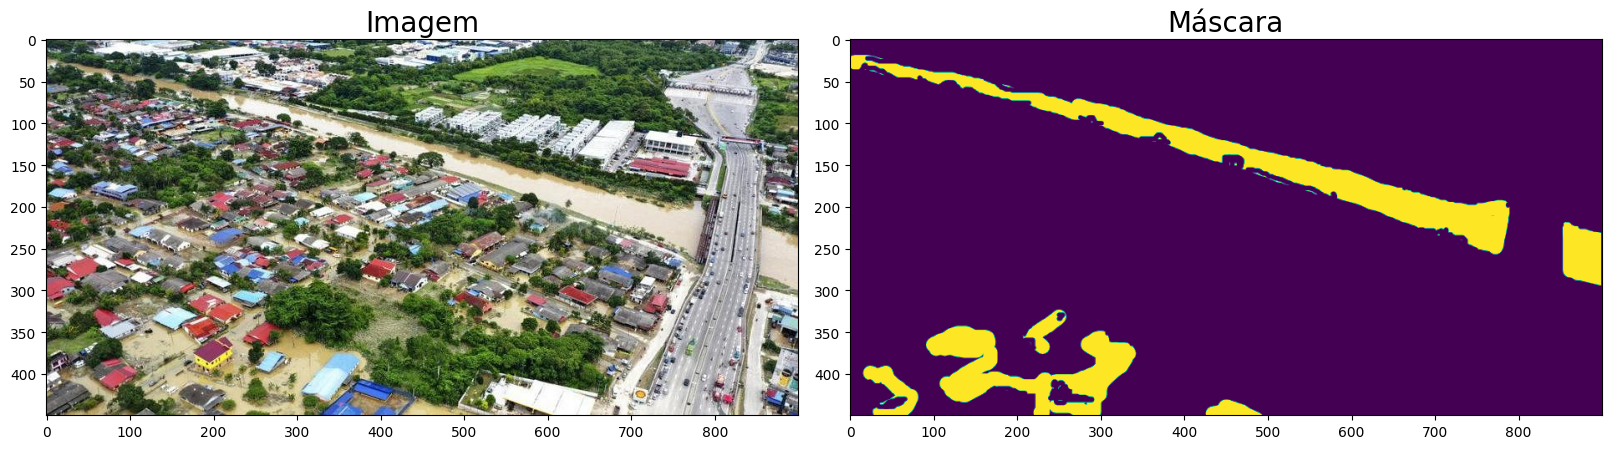

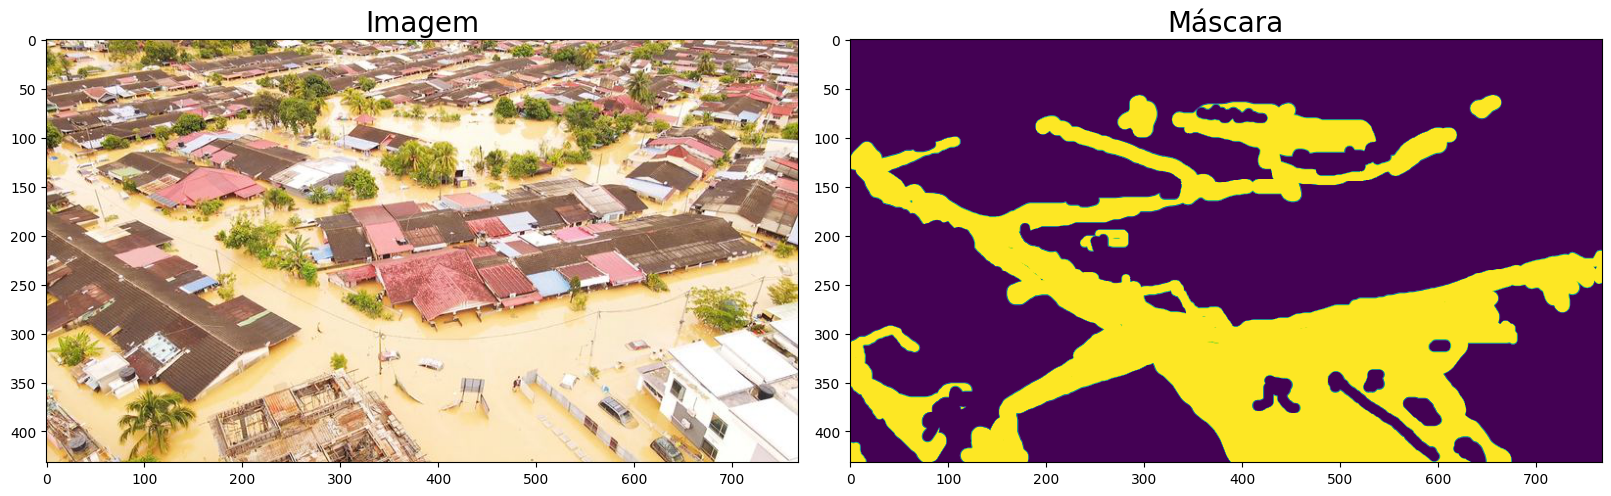

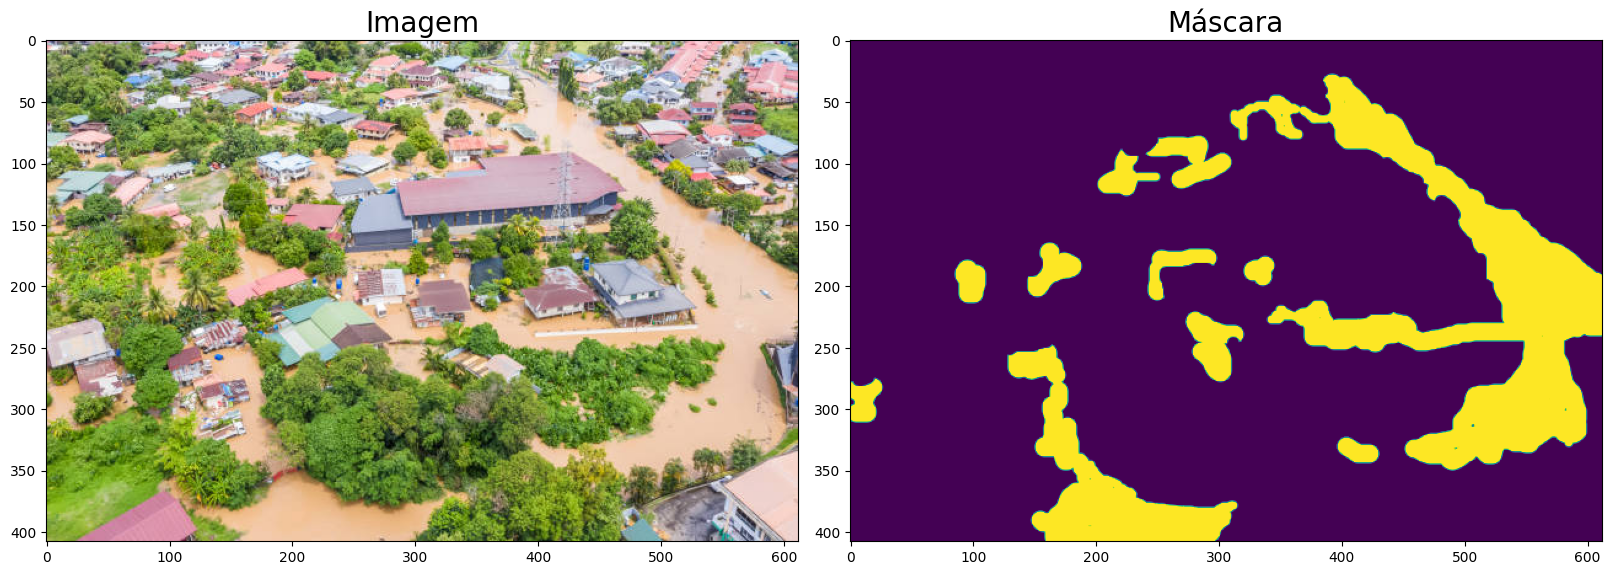

In [129]:
images = os.listdir("/content/dataset/images/test")

# Exibindo as três primeiras imagens de teste e suas máscaras correspondentes
show_data(images[:3], "/content/dataset/images/test/", "/content/dataset/masks/test/")

## Preparação de Dados

## Modelagem e Treinamento

## Avaliação de Resultados